Analyzing Odds Data

    - In the last notebook, we obtained historical odds data from oddsshark, and then augmented our game level data to include the implied probabilities, and over/under lines.

    - We saved that data to a file called 'df_bp3.csv'

    - In this notebook, we will do some initial exploration of that odds data, and compare the quality of our first model predictions to the implied probabilities given by the oddsmakers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)


In [2]:
df = pd.read_csv('df_bp3.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56771 entries, 0 to 56770
Columns: 199 entries, date to over_under_result
dtypes: float64(34), int64(87), object(78)
memory usage: 86.2+ MB


In [4]:
# checks to see if '0-probability' occurs in correct spots

pd.crosstab(df.implied_prob_h>0, df.season)

season,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
implied_prob_h,,,,,,,,,,,,,,,,,,,,,,,,
False,2429,2429,2426,2430,2428,2431,2429,2431,2428,2430,2430,2429,2430,2431,2430,2429,2428,2430,2431,0,0,0,0,0
True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2429,898,2426,2430,2429


In [5]:
df_odds = df[df.season>=2019]

In [6]:
df_odds.sample(5)

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
53384,20220727,0,Wed,ANA,AL,98,KCA,AL,98,4,0,54,D,NaN,NaN,NaN,KAN06,12596.0,168,000020200,000000000,34,9,0,2,0,3,0,0,0,3,1,8,1,0,1,0,6,5,0,0,0,0,27,8,0,1,0,0,34,7,1,0,0,0,0,0,0,1,0,13,0,0,0,0,8,4,3,3,0,0,27,12,2,0,2,0,blakr901,Ryan Blakney,ramoc901,Charlie Ramos,johna901,Adrian Johnson,tumpj901,John Tumpane,NaN,(none),NaN,(none),nevip001,Phil Nevin,mathm001,Mike Matheny,junkj001,Janson Junk,kellb003,Brad Keller,NaN,(none),gossp001,Phil Gosselin,junkj001,Janson Junk,kellb003,Brad Keller,ohtas001,Shohei Ohtani,10,wardt002,Taylor Ward,9,rengl001,Luis Rengifo,6,walsj001,Jared Walsh,3,suzuk001,Kurt Suzuki,2,sierm002,Magneuris Sierra,8,gossp001,Phil Gosselin,5,marsb002,Brandon Marsh,7,stefm001,Michael Stefanic,4,melem001,MJ Melendez,9,merrw001,Whit Merrifield,4,benia002,Andrew Benintendi,10,rivee001,Emmanuel Rivera,5,ohear001,Ryan O'Hearn,3,taylm002,Michael Taylor,8,isbek001,Kyle Isbel,7,gallc001,Cam Gallagher,2,lopen001,Nicky Lopez,6,NaN,Y,2022,-4,0,4,202207270,0.250228,0.228662,0.306043,0.295249,0.388473,0.373276,0.694517,0.668526,125.0,100.0,38.0,33.0,78.0,82.0,0.265734,0.212766,0.322581,0.281221,0.402597,0.340426,0.725178,0.621647,24.0,24.0,11.0,1.0,22.0,14.0,0.565217,0.476190,0.544513,8.5,U
56127,20230814,0,Mon,ANA,AL,120,TEX,AL,119,0,12,51,N,NaN,NaN,NaN,ARL03,27743.0,159,000000000,02300151x,27,1,0,0,0,0,0,0,0,1,0,12,0,0,0,0,1,4,10,10,2,0,24,5,3,0,0,0,37,13,5,0,2,10,1,1,0,8,1,11,1,0,0,0,11,2,0,0,0,0,27,11,0,0,1,0,wendh902,Hunter Wendelstedt,tumpj901,John Tumpane,blakr901,Ryan Blakney,hudsm901,Marvin Hudson,NaN,(none),NaN,(none),nevip001,Phil Nevin,beast801,Tony Beasley,schem001,Max Scherzer,sandp002,Patrick Sandoval,NaN,(none),semim001,Marcus Semien,sandp002,Patrick Sandoval,schem001,Max Scherzer,monim001,Mickey Moniak,8,ohtas001,Shohei Ohtani,10,drurb001,Brandon Drury,4,mousm001,Mike Moustakas,3,rengl001,Luis Rengifo,5,renfh001,Hunter Renfroe,9,thaim001,Matt Thaiss,2,gricr001,Randal Gric

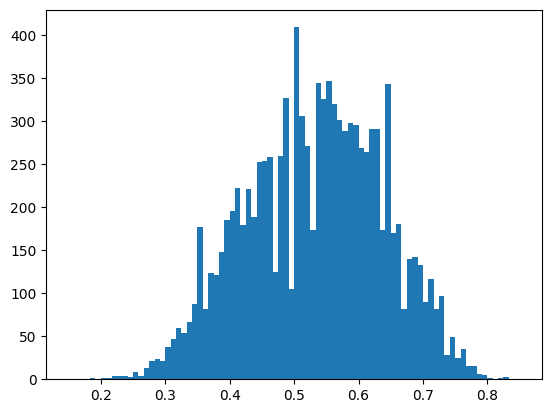

In [7]:
plt.hist(df_odds.implied_prob_h_mid, bins=np.linspace(.15,.85,85));

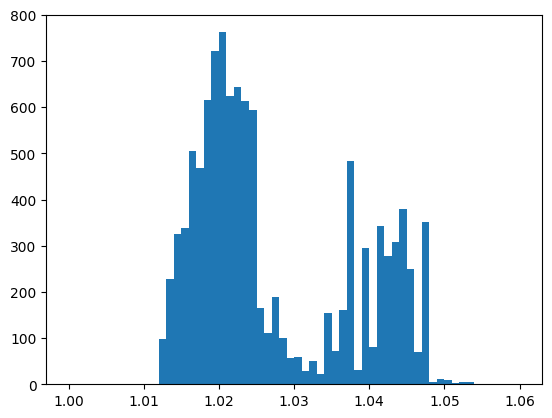

In [8]:
plt.hist(df_odds.implied_prob_h + df_odds.implied_prob_v, bins=np.linspace(1,1.06,61));

# interesting to see second peak around 1.04-1.05 ... IDEAS??

In [9]:
df = df[df.run_diff!=0]
df_train = df[(df.season>2000) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [10]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [11]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()
X_train.shape, X_valid.shape, X_test.shape, 

((36437, 4), (10615, 4), (7285, 4))

In [12]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=3)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689879
[20]	valid_0's binary_logloss: 0.689046
[30]	valid_0's binary_logloss: 0.688214
[40]	valid_0's binary_logloss: 0.687608
[50]	valid_0's binary_logloss: 0.687103
[60]	valid_0's binary_logloss: 0.686731
[70]	valid_0's binary_logloss: 0.686426
[80]	valid_0's binary_logloss: 0.686261
[90]	valid_0's binary_logloss: 0.6862
[100]	valid_0's binary_logloss: 0.685996
[110]	valid_0's binary_logloss: 0.68587
[120]	valid_0's binary_logloss: 0.685746
[130]	valid_0's binary_logloss: 0.685671
[140]	valid_0's binary_logloss: 0.685551
[150]	valid_0's binary_logloss: 0.685518
[160]	valid_0's binary_logloss: 0.685547
[170]	valid_0's binary_logloss: 0.685577
[180]	valid_0's binary_logloss: 0.68559
[190]	valid_0's binary_logloss: 0.685626
[200]	valid_0's binary_logloss: 0.685696
Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.685499


LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators=1000)

In [13]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [14]:
hv_mean = y_train.mean()

In [15]:
lgbm_loss = log_loss(y_test, preds_lgbm)
naive_loss = log_loss(y_test, hv_mean*np.ones(len(y_test)))
lgbm_loss, naive_loss

(0.6855938204898469, 0.6913722730242492)

In [16]:
lv_loss = log_loss(y_test, df_test.implied_prob_h_mid)
lv_loss

0.6704071693200951

In [17]:
(naive_loss - lgbm_loss)/(naive_loss - lv_loss)

0.2756224159891656

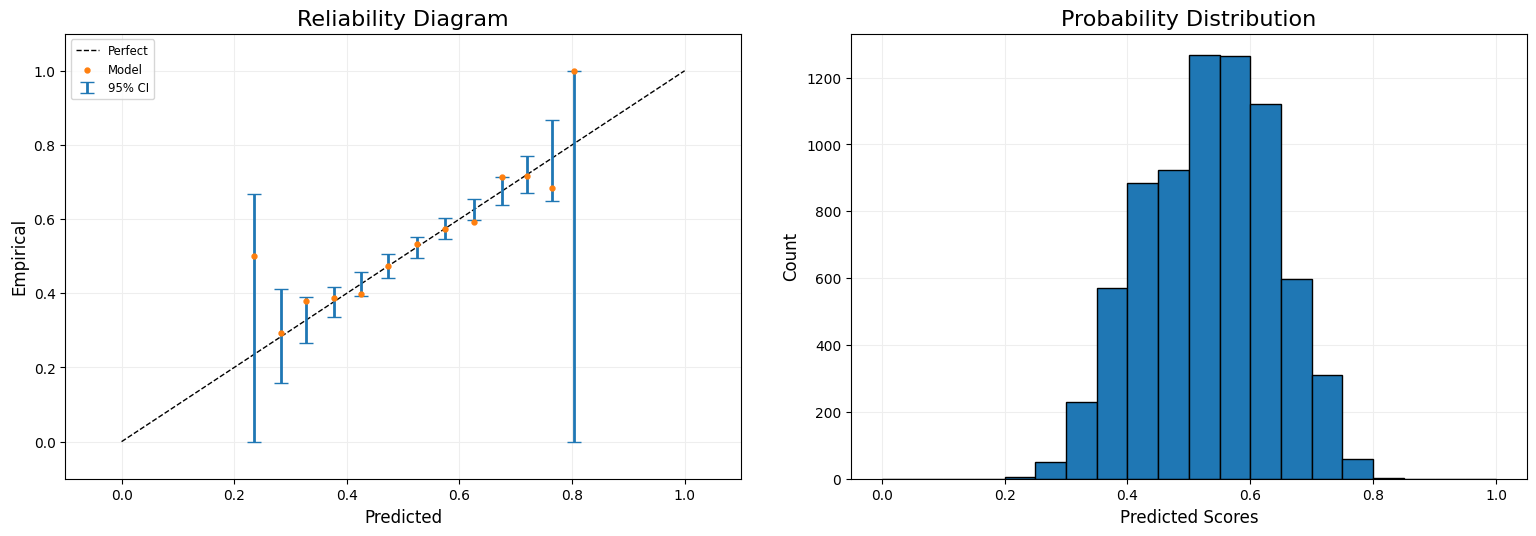

In [18]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, df_test.implied_prob_h_mid, show_histogram=True);

In [19]:
test_disc = np.abs(preds_lgbm - df_test.implied_prob_h_mid)

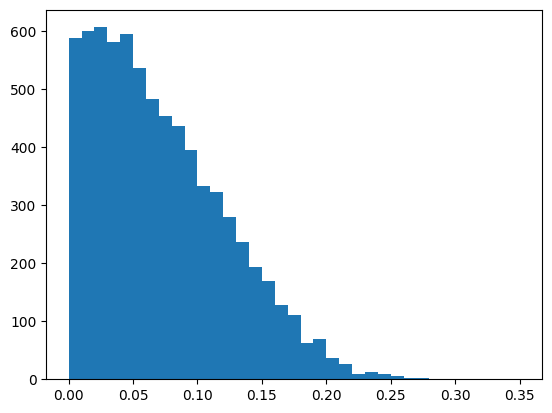

In [20]:
plt.hist(test_disc, np.linspace(0,.35,36));

In [21]:
df_test[test_disc>0.25]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
49585,20210409,0,Fri,WAS,NL,4,LAN,NL,8,0,1,51,D,NaN,NaN,NaN,LOS03,15036.0,151,000000000,00000100x,33,8,1,0,0,0,0,0,0,1,1,10,0,2,0,0,7,4,1,1,0,0,24,9,0,0,1,0,27,4,1,0,1,1,0,0,0,2,0,6,0,0,1,0,4,4,0,0,0,0,27,9,0,0,0,0,barbs901,Sean Barber,gormb901,Brian Gorman,johna901,Adrian Johnson,belld901,Dan Bellino,NaN,(none),NaN,(none),martd002,Dave Martinez,robed001,Dave Roberts,buehw001,Walker Buehler,avill001,Luis Avilan,knebc001,Corey Knebel,turnj001,Justin Turner,rossj002,Joe Ross,buehw001,Walker Buehler,roblv001,Victor Robles,8,turnt001,Trea Turner,6,sotoj001,Juan Soto,9,zimmr001,Ryan Zimmerman,3,casts001,Starlin Castro,5,steva001,Andrew Stevenson,7,garcl006,Luis Garcia,4,lucrj001,Jonathan Lucroy,2,rossj002,Joe Ross,1,taylc001,Chris Taylor,8,seagc001,Corey Seager,6,turnj001,Justin Turner,5,muncm001,Max Muncy,3,smitw003,Will Smith,2,lux-g001,Gavin Lux,4,polla001,A.J. Pollock,7,mckiz001,Zach McKinstry,9,buehw001,Walker Buehler,1,NaN,Y,2021,1,1,1,202104090,0.257261,0.270017,0.331004,0.340100,0.481689,0.458863,0.812693,0.798962,66.0,118.0,12.0,31.0,115.0,81.0,0.275500,0.260042,0.353191,0.332698,0.501430,0.413319,0.854621,0.746017,13.0,25.0,5.0,3.0,23.0,17.0,0.733333,0.285714,0.723810,8.5,U
51471,20210901,0,Wed,NYA,AL,133,ANA,AL,134,4,1,54,D,NaN,NaN,NaN,ANA01,28753.0,170,002100010,000001000,33,8,1,0,1,4,0,0,1,3,0,7,0,1,1,0,6,3,1,1,0,0,27,8,0,0,0,0,31,4,2,0,0,1,0,0,0,0,0,16,0,0,0,0,3,5,4,4,0,0,27,13,0,0,2,0,valej901,Junior Valentine,holbs901,Sam Holbrook,muchm901,Mike Muchlinski,wolfj901,Jim Wolf,NaN,(none),NaN,(none),boona001,Aaron Boone,maddj801,Joe Maddon,coleg001,Gerrit Cole,naugp001,Packy Naughton,chapa001,Aroldis Chapman,voitl001,Luke Voit,coleg001,Gerrit Cole,naugp001,Packy Naughton,lemad001,DJ LeMahieu,4,rizza001,Anthony Rizzo,3,judga001,Aaron Judge,9,voitl001,Luke Voit,10,gallj002,Joey Gallo,7,higak001,Kyle Higashioka,2,odorr001,Rougned Odor,5,velaa001,Andrew Velazquez,6,gardb001,Brett Gardn

In [22]:
# 'Fancy' code that basically says, if the home team is favored then take select their SP. If not, select the oppo SP.

# These are the pitchers that were favored in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']>.5 
 else row[1]['pitcher_start_name_v'] 
 for row in df_test[test_disc>.25].iterrows() ]

['Walker Buehler',
 'Gerrit Cole',
 'Gerrit Cole',
 'Max Fried',
 'Spencer Strider',
 'Jacob deGrom',
 'Chris Bassitt',
 'Mike Clevinger',
 'Yu Darvish',
 'Blake Snell',
 'Yu Darvish',
 'Jacob deGrom',
 'Jacob deGrom',
 'Jacob deGrom']

In [23]:
# These are the underdog pitchers in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']<.5 
 else row[1]['pitcher_start_name_v'] for row in df_test[test_disc>.25].iterrows() ]

['Joe Ross',
 'Packy Naughton',
 'Alexander Wells',
 'Jackson Tetreault',
 'Erasmo Ramirez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Paolo Espino',
 'Anibal Sanchez',
 'Ryan Feltner',
 'Johan Oviedo',
 'Ken Waldichuk']

In [24]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(df_test.implied_prob_h_mid[test_disc>.2], decimals=1))

implied_prob_h_mid,0.2,0.3,0.4,0.7,0.8
home_victory,,,,,
0,3,47,9,3,7
1,3,12,4,13,8


In [25]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(preds_lgbm[test_disc>.2], decimals=1))

col_0,0.5,0.6,0.7
home_victory,,,
0,51,18,0
1,29,10,1


Analysis 

- LV odds are "better" than our current model
- Largest discrepancies appear when we have a strong pitcher vs a weak pitcher
- LV probs seem to be "right" in those cases

CONCLUSION: Need to factor in the starting pitcher to improve our model!